# WGAN
数据集：MNIST  

In [1]:
import argparse
import pdb
import sys
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.autograd as autograd
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

In [2]:
# %% 超参数
dataroot = r"/home/cxmd/文档/data_for_AI_train/mnist_data"
n_epochs = 200          # 训练次数
batch_size = 64        # 批大小
b1 = 0.5                # Adam优化器的beta1参数
b2 = 0.999              # Adam优化器的beta2参数
lr = 0.00005            # 学习率
n_cpu = 8               # cpu数量
latent_dim = 100        # 隐变量维度
img_size = 28           # 图片大小
channels = 1            # 图像通道数
n_critic = 5            # 每次迭代判别器训练的次数
clip_value = 0.01       # 
sample_interval = 400   # 每400次迭代保存一次生成的图片

ngpu = 1                # 使用的GPU数量，使用0表示cpu模式

# Loss weight for gradient penalty
lambda_gp = 10

img_shape = (channels, img_size, img_size)

In [3]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/WGAN/demo1_outf", exist_ok=True)
os.makedirs("images1", exist_ok=True)

训练集

In [4]:
# transform配置
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5,
        ),
    ]
)

In [5]:
# 加载mnist数据，同时将数据按照transform的配置预处理
# 判断是什么操作系统，以设置相应的数据集路径
if sys.platform.startswith('win'):
    datasetpath = 'D:\\nndatasets'
else:
    datasetpath = '/home/cxmd/文档/data_for_AI_train/mnist_data'

mnist = dset.MNIST(
    root=datasetpath,
    train=True,
    transform=transform,
    download=True,
)

In [6]:
# 数据集加载器：GAN为无监督机器学习
# 参数dataset是要加载的数据集，这里是预处理后的mnist数据集
# 参数batch_size是每个批次的样本数量
# 参数shuffle为True表示在每个训练周期开始时，对数据进行重新洗牌
data_loader = torch.utils.data.DataLoader(
    dataset = mnist,
    batch_size=batch_size,
    shuffle=True,
)

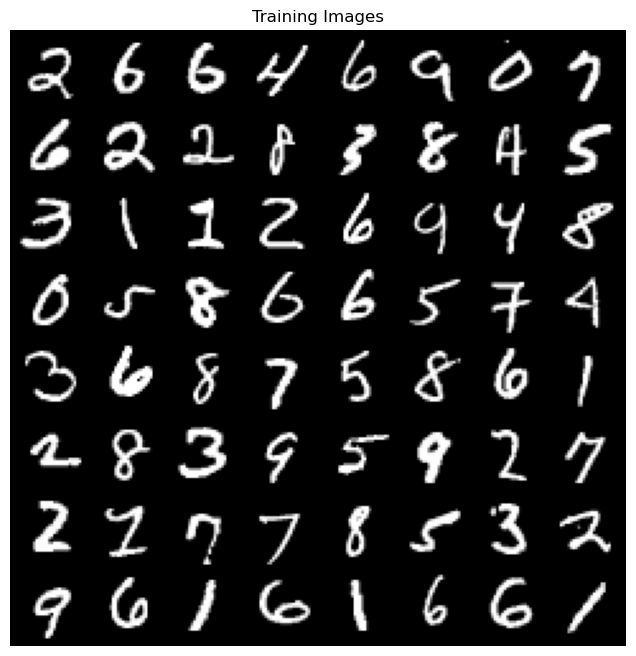

In [7]:
# 选择我们运行在上面的设备
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)
plt.show()

网络

In [8]:
# 生成器
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [9]:
netG = Generator(ngpu).to(device)
print(netG)

# 写入tensorboard
writerG = SummaryWriter('./demo1_outf/Generator')
input_to_netG = torch.randn(batch_size, latent_dim, device=device)
writerG.add_graph(netG, input_to_model=input_to_netG)
writerG.close()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


In [10]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [11]:
netD = Discriminator(ngpu).to(device)
print(netD)

writerD = SummaryWriter('./demo1_outf/Discriminator')
input_to_netD = torch.randn(batch_size, int(np.prod(img_shape)), device=device)
writerD.add_graph(netD, input_to_netD)
writerD.close()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [12]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=real_samples.device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones((real_samples.shape[0], 1), device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Optimizers
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(b1, b2))

训练

In [13]:
batches_done = 0
writer = SummaryWriter('./demo1_outf/')

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # 设置输入
        real_imgs = imgs.to(device)
        
        # ------------------
        #  训练 判别器
        # ------------------
        
        optimizer_D.zero_grad()
        
        # 对噪声采样
        z = torch.randn(imgs.shape[0], latent_dim, device=device)
        
        # 生成器产生一批假图片
        fake_imgs = netG(z).to(device)
        
        real_validity = netD(real_imgs)
        fake_validity = netD(fake_imgs)
        
        if i == 936:
            pass
        # 梯度惩罚
        gradient_penalty = compute_gradient_penalty(netD, real_imgs.data, fake_imgs.data)
        
        # 判别器损失
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        
        d_loss.backward()
        optimizer_D.step()
        
        # ------------------
        #  训练 生成器
        # ------------------
        
        optimizer_G.zero_grad()
        
        if i % n_critic == 0:
        
            fake_imgs = netG(z)
            
            fake_validity = netD(fake_imgs)
            
            # 生成器损失
            g_loss = -torch.mean(fake_validity)
            
            g_loss.backward()
            optimizer_G.step()
            
            # tensorboard跟踪数据
            writer.add_scalar('loss_d', d_loss.item(), epoch*len(data_loader)+i)
            writer.add_scalar('loss_g', g_loss.item(), epoch*len(data_loader)+i)
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
            )
            
            if batches_done % sample_interval == 0:
                save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += n_critic
        
        

[Epoch 0/200] [Batch 0/938] [D loss: 8.129978] [G loss: -0.037205]
[Epoch 0/200] [Batch 5/938] [D loss: 7.389702] [G loss: -0.038293]
[Epoch 0/200] [Batch 10/938] [D loss: 6.424716] [G loss: -0.040502]
[Epoch 0/200] [Batch 15/938] [D loss: 5.115099] [G loss: -0.044231]
[Epoch 0/200] [Batch 20/938] [D loss: 3.330344] [G loss: -0.049921]
[Epoch 0/200] [Batch 25/938] [D loss: 1.155030] [G loss: -0.059420]
[Epoch 0/200] [Batch 30/938] [D loss: -1.501026] [G loss: -0.071327]
[Epoch 0/200] [Batch 35/938] [D loss: -4.472143] [G loss: -0.089525]
[Epoch 0/200] [Batch 40/938] [D loss: -7.800273] [G loss: -0.115603]
[Epoch 0/200] [Batch 45/938] [D loss: -11.082170] [G loss: -0.157358]
[Epoch 0/200] [Batch 50/938] [D loss: -14.768376] [G loss: -0.202417]
[Epoch 0/200] [Batch 55/938] [D loss: -17.906820] [G loss: -0.266115]
[Epoch 0/200] [Batch 60/938] [D loss: -20.974583] [G loss: -0.346204]
[Epoch 0/200] [Batch 65/938] [D loss: -23.751804] [G loss: -0.430680]
[Epoch 0/200] [Batch 70/938] [D loss: